In [2]:
import os
os.environ['KERAS_BACKEND'] = "tensorflow"

In [3]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow as tf
# from keras import backend as K
import keras.backend.tensorflow_backend as K
K.set_session

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as keras

from skimage.filters import threshold_yen, threshold_otsu
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import svm
import umap


Using TensorFlow backend.


In [4]:
keras.backend()

'tensorflow'

### umap test:

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()
embedding = umap.UMAP().fit_transform(digits.data)

### start research:

In [6]:
os.getcwd()
TRAIN_PATH = "data/stage1_train/"
train_ids = next(os.walk(TRAIN_PATH))[1]

In [7]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

## Train data loader function

In [8]:

def load_train_data(number_of_img=None):
    X_train_ = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train_ = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sys.stdout.flush()
    print('Getting and resizing train images and masks ... ')
    enumerate_coll = tqdm(enumerate(train_ids), total=len(train_ids))
    for n, id_ in enumerate_coll:
        if number_of_img and number_of_img == n:
            break
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train_[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train_[n] = mask
    return X_train_, Y_train_


In [9]:
X, Y = load_train_data()

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [04:44<00:00,  2.35it/s]


In [10]:
split_th = round(len(train_ids)*0.85)

In [11]:
X_train = X[:split_th]
Y_train = Y[:split_th]
X_test = X[split_th:]
Y_test = Y[split_th:]
number_of_train_samples = len(X_train)
number_of_test_samples = len(X_test)
print("number of train samples: ", number_of_train_samples, "  number of test samples: ", number_of_test_samples)

number of train samples:  570   number of test samples:  100


In [12]:
def simple_iou(component1,component2):
    overlap = component1*component2 # Logical AND
    union = component1 + component2 # Logical OR
    union = (union > 0).astype(np.uint8)
    IOU = overlap.sum()/float(union.sum())
    return IOU

### Plot Data

In [13]:
def remove_axis(ax):
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return

In [14]:
def plot_original_data(x_data = X_train, y_data = Y_train, number_of_img=10, indent = 0):
    f, axarr = plt.subplots(3,number_of_img,figsize=(20,6))
    for i in range(0,number_of_img): 
        index = i + indent
        axarr[0,i].imshow(x_data[index])
        axarr[1,i].imshow(np.squeeze(y_data[index]))

        axarr[2,i].hist(x_data[index].ravel(), bins=256, range=(0.0, 256.0))
        for j in range(0,3):
            remove_axis(axarr[j,i])

    axarr[0,0].set_ylabel("Image", rotation=90, size='large')
    axarr[1,0].set_ylabel("Segmentation ", rotation=90, size='large')
    axarr[2,0].set_ylabel("Histogram", rotation=90, size='large')
    for j in range(0,3):
            axarr[j,0].get_yaxis().set_visible(True)
            axarr[j,0].set_yticklabels([])
            
    f.suptitle("Images (X) Segmentation (Y) and Histogram", fontsize=20)

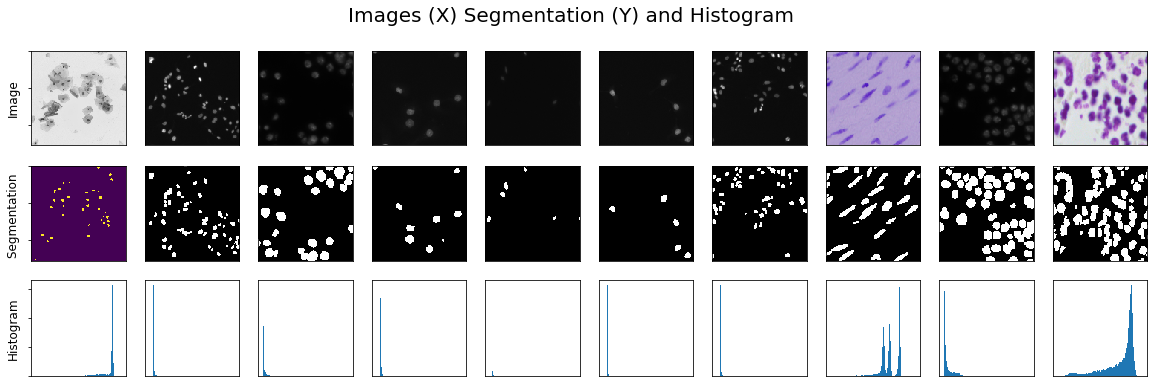

In [15]:
plot_original_data(indent = 25)

# Investigate Data

In [232]:
def scatter_images_plot(images, embedding, unique_labels, colors, labels, title = "UMAP embedding of images"):

    def imscatter(x, y, images, ax=None, zoom=1.0):
        if ax is None:
            ax = plt.gca()
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0, img0 in zip(x, y, images):
            im = offsetbox.OffsetImage(img0, zoom=zoom)
            ab = offsetbox.AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists

    def plot_embedding(X, imgs):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax = plt.subplot(111)
        for i in range(X.shape[0]):
            plt.text(X[i, 0], X[i, 1], ".", fontdict={'weight': 'bold', 'size': 9})
        if hasattr(offsetbox, 'AnnotationBbox'):
            imscatter(X[:,0], X[:,1], imgs, zoom=0.25, ax=ax)
            

    plot_embedding(embedding, X_train)
    plt.title(title, fontsize=20)
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue
        class_member_mask = (labels == k)
        xy = embedding[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=50)

In [233]:
pca1 = PCA(n_components=2)
pca_regular_embedding = pca1.fit_transform([x.reshape(49152) for x in X_train])

In [234]:
regular_umap = umap.UMAP(n_neighbors=3)
regular_embedding = regular_umap.fit_transform([x.reshape(49152) for x in X_train])

C:\Users\Sharon\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


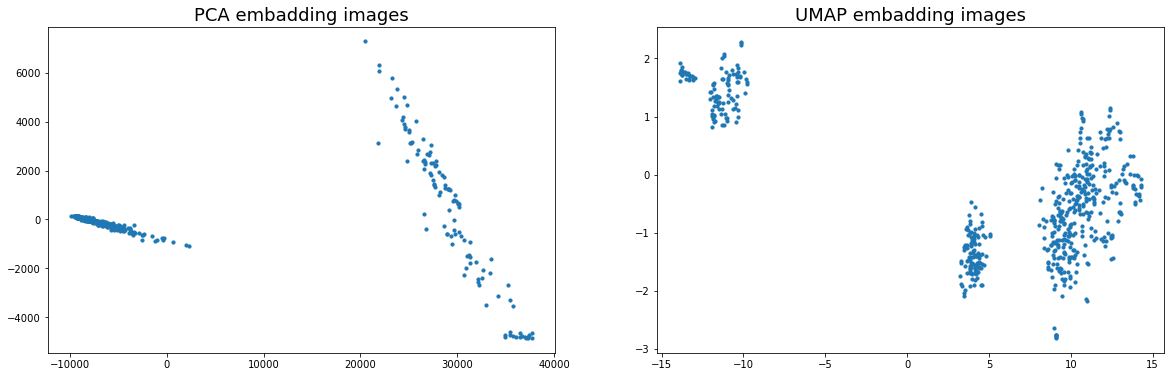

In [249]:
f, axarr = plt.subplots(1,2,figsize=(20,6))
axarr[0].scatter(pca_regular_embedding[:, 0], pca_regular_embedding[:, 1], s=10)
axarr[0].set_title("PCA embadding images", fontsize=18)
axarr[1].scatter(regular_embedding[:, 0], regular_embedding[:, 1], s=10)
axarr[1].set_title("UMAP embadding images", fontsize=18)
plt.show()


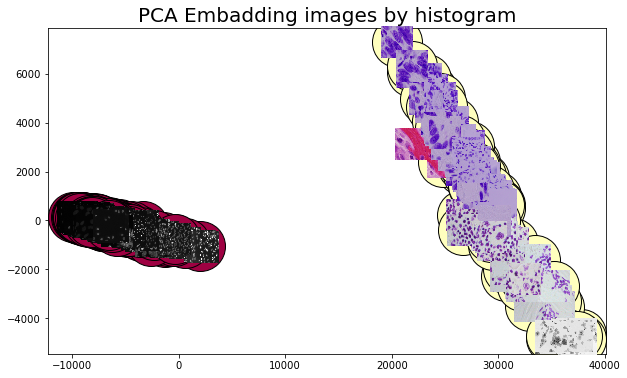

In [236]:
# db = DBSCAN(eps=1500, min_samples=10).fit(pca_regular_embedding)
db = DBSCAN(eps=12000, min_samples=10).fit([x.reshape(49152) for x in X_train])
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

title =  "PCA Embadding images by histogram"
scatter_images_plot(X_train, pca_regular_embedding, unique_labels, colors, labels, title)



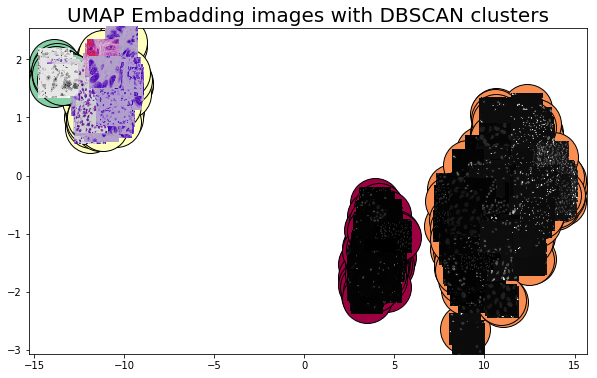

In [237]:
db = DBSCAN(eps=0.7, min_samples=10).fit(regular_embedding)
# db = DBSCAN(eps=6500, min_samples=10).fit([x[0] for x in X_train_hist])
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

title =  "UMAP Embadding images with DBSCAN clusters"
scatter_images_plot(X_train, regular_embedding, unique_labels, colors, labels, title)

In [238]:
def create_histogram_mapping(labels, X_train):
    hist_group = {}
    for index, (label, x_sample) in enumerate(zip(labels, X_train)):
        if label not in hist_group:
            hist_group[label] = []
        hist_group[label].append(index)
    return hist_group

In [239]:
def plot_clusters_images(hist_group, title):
    f, axarr = plt.subplots(6,len(hist_group.keys()),figsize=(20,10))

    for index, (_, sampels_indexes) in enumerate(hist_group.items()):
        for sample_index in range(0, 6, 2):
            indent = 2
            if sample_index + indent < len(sampels_indexes):
                axarr[sample_index,index].imshow(X_train[sampels_indexes[sample_index +indent ]])
                axarr[sample_index+1,index].hist(X_train[sampels_indexes[sample_index+indent ]].ravel(), bins=256, range=(0.0, 256.0))
            remove_axis(axarr[sample_index,index])
            remove_axis(axarr[sample_index+1,index])

        axarr[0,index].set_xlabel("group {} :{}#s".format(index, len(sampels_indexes)), rotation=0, size='large')
        axarr[0,index].xaxis.set_label_position('top') 
        axarr[0,index].get_xaxis().set_visible(True)
        axarr[0,index].set_xticklabels([])

    f.suptitle(title, fontsize=20)
    

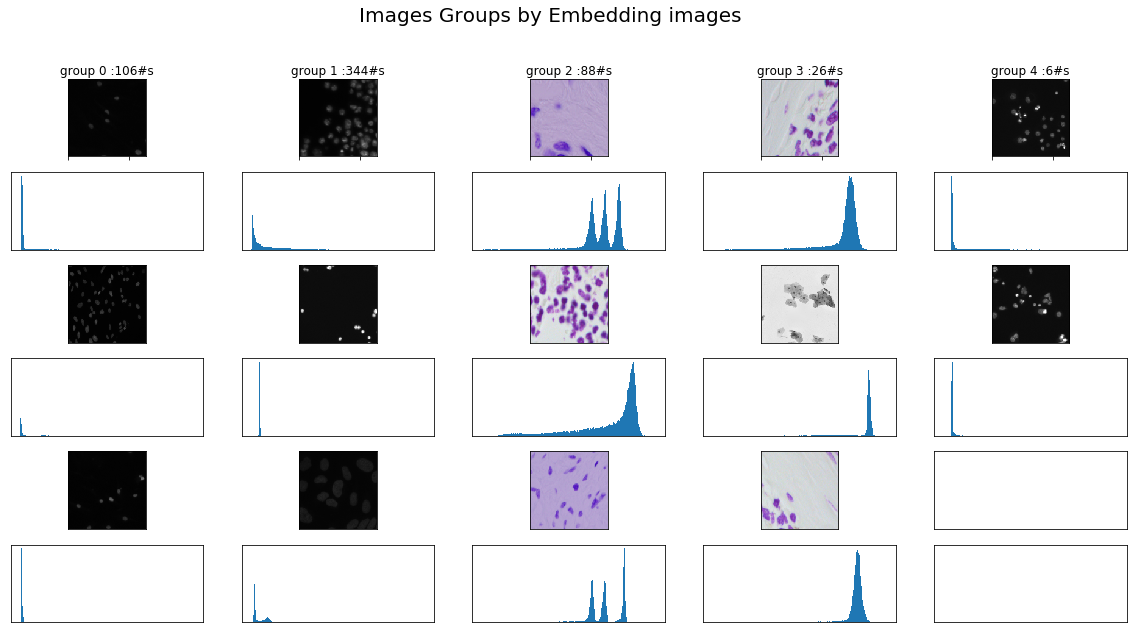

In [240]:
hist_group = create_histogram_mapping(labels, X_train)
plot_clusters_images(hist_group,"Images Groups by Embedding images")


## Group by Hist

In [241]:
X_train_hist = []
for i in range(0,len(X_train)):
    X_train_hist.append(np.histogram(X_train[i], bins=256, range=(0.0, 256.0)))

In [242]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform([x[0] for x in X_train_hist])

In [243]:
histogram_umap = umap.UMAP(n_neighbors=30,metric='correlation')
hist_embedding = histogram_umap.fit_transform([x[0] for x in X_train_hist])

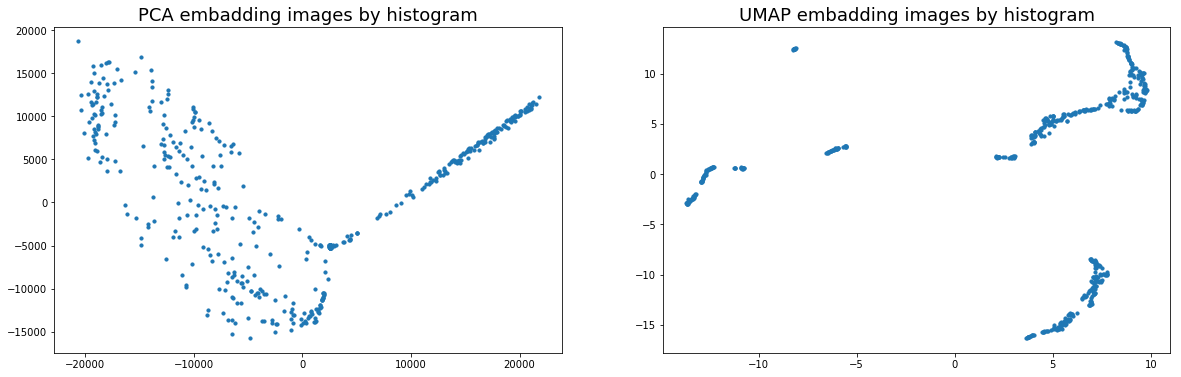

In [250]:
f, axarr = plt.subplots(1,2,figsize=(20,6))
axarr[0].scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=10)
axarr[0].set_title("PCA embadding images by histogram", fontsize=18)
axarr[1].scatter(hist_embedding[:, 0], hist_embedding[:, 1], s=10)
axarr[1].set_title("UMAP embadding images by histogram", fontsize=18)
plt.show()


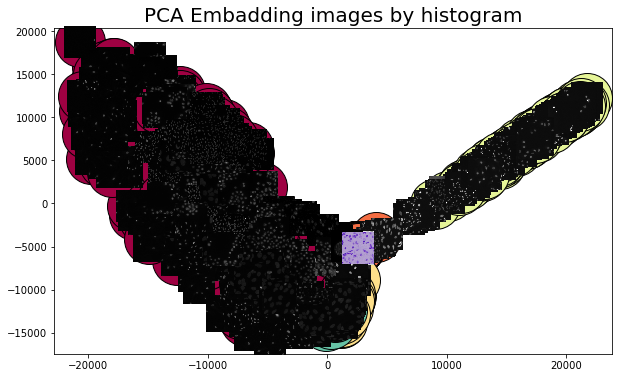

In [245]:
db = DBSCAN(eps=1000, min_samples=10).fit(pca_embedding)
db = DBSCAN(eps=6000, min_samples=10).fit([x[0] for x in X_train_hist])
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

title =  "PCA Embadding images by histogram"
scatter_images_plot(X_train, pca_embedding, unique_labels, colors, labels, title)

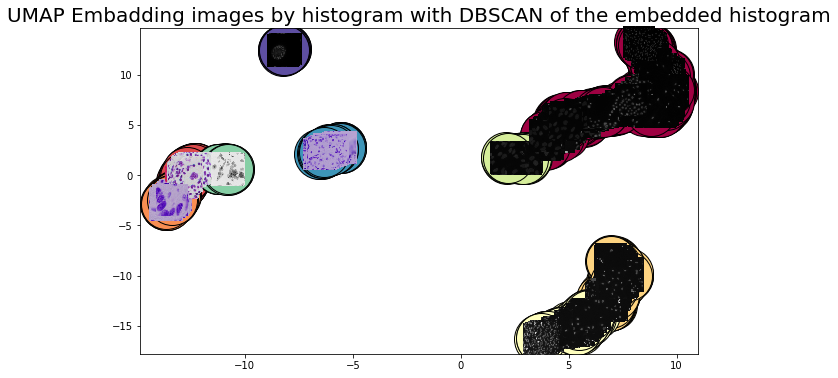

In [246]:
db = DBSCAN(eps=0.85, min_samples=10).fit(hist_embedding)
# db = DBSCAN(eps=10000, min_samples=30).fit([x[0] for x in X_train_hist])
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

title =  "UMAP Embadding images by histogram with DBSCAN of the embedded histogram"
scatter_images_plot(X_train, hist_embedding, unique_labels, colors, labels, title)

In [247]:
labels.shape, X_train.shape

((570,), (570, 128, 128, 3))

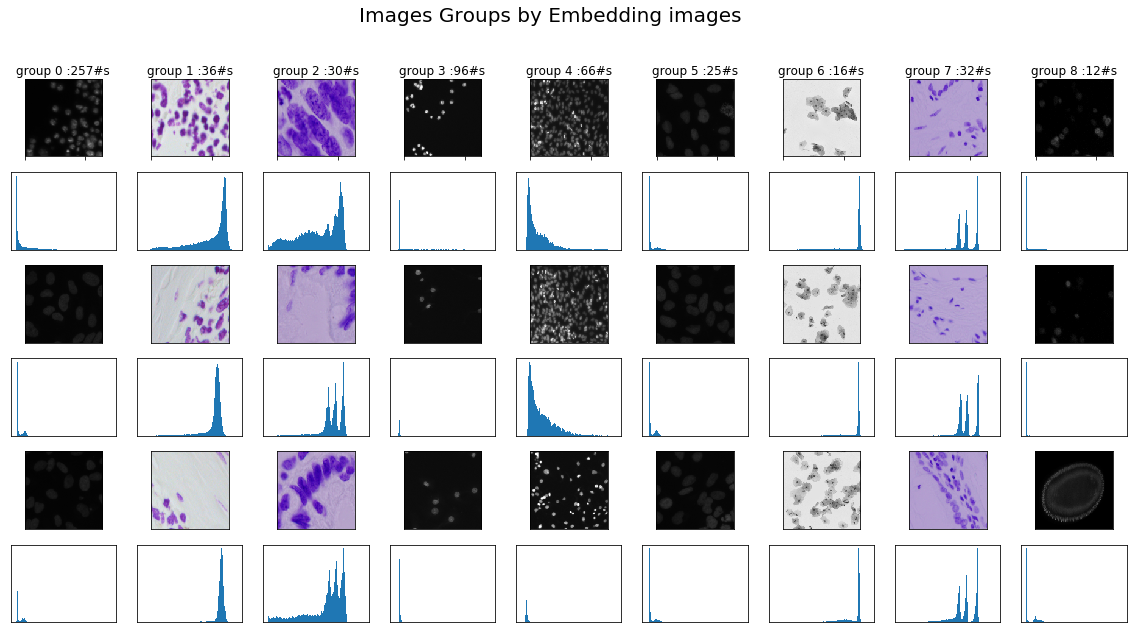

In [251]:
hist_group = create_histogram_mapping(labels, X_train)
plot_clusters_images(hist_group, "Images Groups by Embedding images")

# SVM

### choose kernel

In [ ]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
model_x = hist_embedding
model_y = db.labels_

C = 0.1  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=1.5, C=1),
          svm.SVC(kernel='poly', degree=2, C=C),
         svm.SVC(kernel='poly', degree=3, C=C),
         svm.SVC(kernel='poly', degree=3, C=C))

models = (clf.fit(model_x, model_y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 2) kernel',
         'SVC with polynomial (degree 3) kernel',
         'SVC with polynomial (degree 4) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 3, figsize=(15, 12))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = model_x[:, 0], model_x[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=model_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_title(title)
    
fig.suptitle("SVM for embedded images By histogram")

plt.show()

### create a pipeline component

In [ ]:
class HistogramEmbeddingSVM:
    def __init__(self, eps=0.6, min_samples=10, kernel='linear', C=0.1):
        self.histogram_umap = umap.UMAP()
        self.eps = eps
        self.min_samples = min_samples
        self.svm = svm.SVC(kernel=kernel, C=C)
          
    def transform(self, X):
        labels = predict(X)
        # TODO: add labels as channel or value to X
        return X, labels
    
    def fit_transform(self, X, Y=None):
        X_train_hist = [np.histogram(x, bins=256, range=(0.0, 256.0))[0] for x in X]
        hist_embedding = self.histogram_umap.fit_transform(X_train_hist)
        db = DBSCAN(eps=0.6, min_samples=10).fit(hist_embedding)
        self.svm.fit(hist_embedding, db.labels_)
        # TODO: add labels as channel or value to X
        return X, db.labels_
    
    def predict(self, X):
        X_train_hist = [np.histogram(x, bins=256, range=(0.0, 256.0))[0] for x in X]
        hist_embedding = self.histogram_umap.transform(X_train_hist)
        return self.svm.predict(hist_embedding)
        

## Thresholding Method

In [ ]:
f, axarr = plt.subplots(1,2,figsize=(6,5))
axarr[0].imshow(X_train[0])
axarr[1].imshow(np.squeeze(Y_train[0]))
remove_axis(axarr[0])
remove_axis(axarr[1])
axarr[0].set_title("Original Image")
axarr[1].set_title("Mask")

In [ ]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(X_train[0][:, :, 0], figsize=(8, 10), verbose=False)
plt.show()

In [ ]:
plt.hist(X_test[0].ravel(), bins=256, range=(0.0, 256.0))
plt.plot([70, 70], [0, 14000], 'k-', lw=2)
plt.show()

### Threshold Yen

In [ ]:
def simple_th(image):
    thresh = threshold_yen(image)
    binary = np.array( image > thresh, dtype=int)
    return thresh ,binary
    

In [ ]:
from skimage.filters import threshold_yen

def plot_threshold_yen(i=0, th_method = simple_th):
    image = X_train[i][:, :, 0]
    thresh ,binary = th_method(image)
    f, axarr = plt.subplots(1,4,figsize=(15,3))
    axarr[0].imshow(X_train[i])
    axarr[0].set_title("original nuclei image")
    axarr[2].imshow(np.squeeze(Y_train[i]))
    axarr[2].set_title("Image segmentation (ground truth)")
    axarr[1].imshow(binary)
    axarr[1].set_title("Yen threshold")

    
    x_ravel = np.histogram(X_train[i].ravel(), bins=256, range=(0.0, 256.0))
    
    axarr[3].hist(X_train[i].ravel(), bins=256, range=(0.0, 256.0))
    axarr[3].plot([thresh, thresh], [0, max(x_ravel[0])], 'k-', lw=2)
    axarr[3].set_title("histogram")
    
    for i in range(0,4):
        remove_axis(axarr[i])

plot_threshold_yen(i=0)


In [ ]:
plot_threshold_yen(i=2)

In [ ]:
def smart_thresholding(image , th_method = threshold_yen):
    thresh = th_method(image)
    
    x_ravel = np.histogram(image.ravel(), bins=256, range=(0.0, 256.0))
    max_index = list(x_ravel[0]).index(max(x_ravel[0]))
    max_value, max_th = (x_ravel[0][max_index], x_ravel[1][max_index])
    
    if max_th < thresh:
        binary = np.array( image > thresh, dtype=int)
    else:
        binary = np.array( image < thresh, dtype=int)
        
    return thresh ,binary


In [ ]:
plot_threshold_yen(i=0,th_method=smart_thresholding)

In [ ]:
plot_threshold_yen(i=2,th_method=smart_thresholding)

In [ ]:
image = X_test[0][:, :, 0]
thresh ,binary = smart_thresholding(image)
simple_iou(binary,np.squeeze(Y_test[0]))

In [ ]:
iou_sum = 0
len1 = 0
for i in range(0,100):
    image = X_test[i][:, :, 0]
    thresh ,binary = smart_thresholding(image)
    iou_sum += simple_iou(binary,np.squeeze(Y_test[i]))
    len1 += 1
print(iou_sum/ len1, len1)

### Threshold Otsu

In [ ]:
iou_sum = 0
len1 = 0
for i in range(0,100):
    image = X_test[i][:, :, 0]
    thresh ,binary = smart_thresholding(image, th_method=threshold_otsu)
    iou_sum += simple_iou(binary,np.squeeze(Y_test[i]))
    len1 += 1
print(iou_sum/ len1, len1)

## Show IoU idea

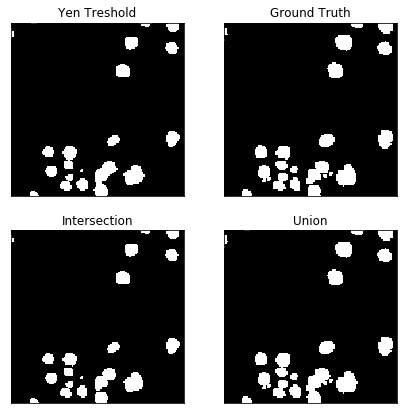

In [21]:

image = X_train[0][:, :, 0]
thresh = threshold_yen(image)
component1 = np.array( image > thresh, dtype=int)
component2 = np.squeeze(Y_train[0])

overlap = component1*component2
iou = component1 + component2
union = (iou > 0).astype(np.uint8)

f, axarr = plt.subplots(2,2,figsize=(7,7))
axarr[0,0].set_title("Yen Treshold")
axarr[0,0].imshow(component1)
axarr[0,1].set_title("Ground Truth")
axarr[0,1].imshow(component2)
axarr[1,0].set_title("Intersection")
axarr[1,0].imshow(overlap)
axarr[1,1].set_title("Union")
axarr[1,1].imshow(union)

for i in range(0,2):
    for j in range(0,2):
        remove_axis(axarr[i,j])


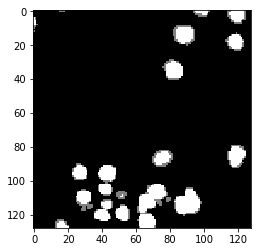

In [22]:
plt.imshow(iou)

# KERAS Models

### models names:

In [23]:
FCN_model_name = 'FCN-v1'
Unet_model_name = 'U-net-v1'
large_Unet_model_name = 'large-U-net-v1'

In [24]:
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.1
EPOCHS = 100
START_LR = 1e-3
END_LR = 1e-4

### calc learning rate decay step:

In [25]:
number_of_updates = round(round(number_of_train_samples*(1-VALIDATION_SPLIT))*EPOCHS/BATCH_SIZE)
LR_DECAY = (START_LR - END_LR)/number_of_updates
LR_DECAY

1.40361821584529e-07

### model default training:

In [26]:
def train_keras_model(model, model_name, epochs_= EPOCHS):
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, 
                        validation_split=VALIDATION_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epochs_, 
                        verbose=0,
                        callbacks=[earlystopper, checkpointer])
    return results

## FCN

In [27]:
def FCN_v1(input_size = (128,128,3)):
    inputs = Input(input_size)
    conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     drop = Dropout(0.25)(conv)
#     conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop)
    conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(1, 1, activation = 'sigmoid')(conv)
    model = Model(input = inputs, output = conv)
    return model 

In [28]:
FCN_v1().summary()

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 4)       292       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 2)       74        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 1)       3         
Total params: 1,177
Trainable params: 1,177
Non-trainable params: 0
_________________________________________________________________


In [205]:
model = FCN_v1()
model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
train_keras_model(model, FCN_model_name, epochs_=100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 00000: val_loss improved from inf to 0.67366, saving model to FCN-v1.h5
Epoch 00001: val_loss improved from 0.67366 to 0.65283, saving model to FCN-v1.h5
Epoch 00002: val_loss improved from 0.65283 to 0.63394, saving model to FCN-v1.h5
Epoch 00003: val_loss improved from 0.63394 to 0.61634, saving model to FCN-v1.h5
Epoch 00004: val_loss improved from 0.61634 to 0.60004, saving model to FCN-v1.h5
Epoch 00005: val_loss improved from 0.60004 to 0.58541, saving model to FCN-v1.h5
Epoch 00006: val_loss improved from 0.58541 to 0.57172, saving model to FCN-v1.h5
Epoch 00007: val_loss improved from 0.57172 to 0.55907, saving model to FCN-v1.h5
Epoch 00008: val_loss improved from 0.55907 to 0.54743, saving model to FCN-v1.h5
Epoch 00009: val_loss improved from 0.54743 to 0.53674, saving model to FCN-v1.h5
Epoch 00010: val_loss improved from 0.53674 to 0.52685, saving model to FCN-v1.h5
Epoch 00011: val_loss improved from 0.52685 to 0.51762, saving model to FCN-v1.h5
Epoch 00012: val_los

## U-net

In [29]:

def Contracting(inputs, dim):
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv )
    return pool , conv

def Expansive(inputs, parallel_conv, dim):
    up = Conv2D(dim, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(inputs))
    
    merge_l = concatenate([parallel_conv,up], axis=3)
#     merge_l = merge([parallel_conv,up], mode = 'concat', concat_axis = 3)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_l)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    return conv

def Conv_n_Dropout(inputs, dim):
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    drop = Dropout(0.5 ,  name='decoder')(conv)
    return drop
    

In [30]:
def unet(input_size = (128,128,3)):
    """
    this is an my implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i used 128x128x3 -> 4 ->8 -> 16 ->32 in order to test it on my own cpu 
    i also excluded one pooling group 
    """
    inputs = Input(input_size)
    contract4, conv4 = Contracting(inputs, 4)
    contract8, conv8 = Contracting(contract4, 8)
    contract16, conv16 = Contracting(contract8, 16)
    convolve_n_drop32 = Conv_n_Dropout(contract16, 32)
    expan16 = Expansive(convolve_n_drop32, conv16, 16)
    expan8 = Expansive(expan16, conv8, 8)
    expan4 = Expansive(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    model = Model(inputs = inputs, outputs = conv1)

    return model

In [253]:
model = unet()
model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "{}_LR_DECAY_from_{}_to_{}.h5".format(Unet_model_name, START_LR, END_LR)
print(model_name)
train_keras_model(model,model_name, epochs_=100)

U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00000: val_loss improved from inf to 0.30739, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.30739 to 0.26827, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.26827 to 0.22208, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.22208 to 0.21183, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.21183 to 0.20723, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.20723 to 0.20297, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.20297 to 0.20207, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.20207 to 0.2

## large unet Model

In [31]:
def large_unet(input_size = (128,128,3)):
    """
    this is an my implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i used 128x128x3 -> 4 ->8 -> 16 ->32 -> 64 in order to test it on my own cpu 
    """
    inputs = Input(input_size)
    lambda1 = Lambda(lambda x: x / 255) (inputs)
    contract4, conv4 = Contracting(lambda1, 4)
    contract8, conv8 = Contracting(contract4, 8)
    contract16, conv16 = Contracting(contract8, 16)
    contract32, conv32 = Contracting(contract16, 32)
    convolve_n_drop64 = Conv_n_Dropout(contract32, 64)
    expan32 = Expansive(convolve_n_drop64, conv32, 32)
    expan16 = Expansive(expan32, conv16, 16)
    expan8 = Expansive(expan16, conv8, 8)
    expan4 = Expansive(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    autoencoder = Model(input = inputs, output = conv1)
    
    encoder = Model(inputs, convolve_n_drop64)
    
#     print([x.name for x in autoencoder.layers])
    # create a placeholder for an encoded input
    encoded_input = Input(shape= (8, 8, 64), name="encoded_input")
    decoder_layer = autoencoder.get_layer("decoder")
    decoder = Model(encoded_input, decoder_layer(encoded_input), name="decoder")
    
    return autoencoder, encoder, decoder

In [383]:
model, encoder, decoder = large_unet()

model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "{}_LR_DECAY_from_{}_to_{}.h5".format(large_Unet_model_name, START_LR, END_LR)

train_keras_model(model, model_name, epochs_=100)

decoder.save("decoder_{}".format(model_name))
encoder.save("encoder_{}".format(model_name))

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


['input_28', 'lambda_17', 'conv2d_491', 'conv2d_492', 'max_pooling2d_83', 'conv2d_493', 'conv2d_494', 'max_pooling2d_84', 'conv2d_495', 'conv2d_496', 'max_pooling2d_85', 'conv2d_497', 'conv2d_498', 'max_pooling2d_86', 'conv2d_499', 'conv2d_500', 'decoder', 'up_sampling2d_75', 'conv2d_501', 'concatenate_75', 'conv2d_502', 'conv2d_503', 'up_sampling2d_76', 'conv2d_504', 'concatenate_76', 'conv2d_505', 'conv2d_506', 'up_sampling2d_77', 'conv2d_507', 'concatenate_77', 'conv2d_508', 'conv2d_509', 'up_sampling2d_78', 'conv2d_510', 'concatenate_78', 'conv2d_511', 'conv2d_512', 'conv2d_513', 'conv2d_514']
Epoch 00000: val_loss improved from inf to 0.46044, saving model to large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.46044 to 0.41474, saving model to large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.41474 to 0.33229, saving model to large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.3

## Model Evaluation Utils

In [32]:
def find_best_threshold(pred_data, compared_data):
    if len(pred_data) != len(compared_data):
        raise Exception("invalid compared shapes, {} != {}".format(len(pred_data),len(compared_data)))
    thresholds = []
    for i in range(0,len(pred_data)):
        best_t = 0
        best_iou = 0
        for t in np.linspace(0,1,101):
            iou = simple_iou(np.squeeze(pred_data[i]> t),np.squeeze(compared_data[i]))
            if iou > best_iou:
                best_iou = iou
                best_t = t
        thresholds.append(best_t)
    return sum(thresholds) / float(len(thresholds))

In [33]:
def get_threshold():
    best_train_th = find_best_threshold(preds_train, Y_train)
    best_test_th = find_best_threshold(preds_test, Y_test)
    print("train threshold: " , best_train_th, " test threshold: ", best_test_th )
    if  best_train_th - best_test_th > 0.001:
        print("WARNING: model best threshold is not efficient, bias: {}".format(best_train_th - best_test_th))
    return best_train_th, best_test_th

In [34]:
def predict_segmentetion_plot(model_name, number_of_plots = 3):
    f, axarr = plt.subplots(number_of_plots ,4,figsize=(15.5,10))
    for i in range(0,number_of_plots):
        axarr[i,0].imshow(X_test[i])
        axarr[i,1].imshow(np.squeeze(Y_test[i]))
        axarr[i,2].imshow(np.squeeze(preds_test[i]))
        axarr[i,3].imshow(np.squeeze(preds_test_th[i]))
        for j in range(0,4):
            remove_axis(axarr[i,j])
            
        axarr[0,0].set_title("Original nuclei image")
        axarr[0,1].set_title("Image segmentation (ground truth)")
        axarr[0,2].set_title(model_name)
        axarr[0,3].set_title("Clean {}".format(model_name))
    
    return f, axarr

In [35]:
def get_model_mean_iou():
    iou_sum = 0
    len1 = 0
    for i in range(0,len(Y_test)):
        iou_sum += simple_iou(np.squeeze(preds_test_th[i]),np.squeeze(Y_test[i]))
        len1 += 1
    print("mean test IOU: ", iou_sum/ len1, " number of samples: ", len1)
    
    iou_sum = 0
    len1 = 0
    for i in range(0,len(Y_train)):
        iou_sum += simple_iou(np.squeeze(preds_train_th[i]),np.squeeze(Y_train[i]))
        len1 += 1
    print("mean train IOU: ", iou_sum/ len1, " number of samples: ", len1)
    

In [62]:
def get_threshold_local(preds_train, preds_test):
    best_train_th = find_best_threshold(preds_train, Y_train)
    best_test_th = find_best_threshold(preds_test, Y_test)
    print("train threshold: " , best_train_th, " test threshold: ", best_test_th )
    if  best_train_th - best_test_th > 0.001:
        print("WARNING: model best threshold is not efficient, bias: {}".format(best_train_th - best_test_th))
    return best_train_th, best_test_th

In [136]:
def predict_segmentetion_plot_local(model_name,  preds_test, preds_test_th, number_of_plots = 2):
    f, axarr = plt.subplots(number_of_plots ,4,figsize=(15.5,8))
    for i in range(0,number_of_plots):
        axarr[i,0].imshow(X_test[i])
        axarr[i,1].imshow(np.squeeze(Y_test[i]))
        axarr[i,2].imshow(np.squeeze(preds_test[i]))
        axarr[i,3].imshow(np.squeeze(preds_test_th[i]))
        for j in range(0,4):
            remove_axis(axarr[i,j])
            
        axarr[0,0].set_title("Original nuclei image")
        axarr[0,1].set_title("Image segmentation (ground truth)")
        axarr[0,2].set_title("model")
        axarr[0,3].set_title("Clean model")
    
    return f, axarr

In [68]:
def get_model_mean_iou_local(preds_test_th, preds_train_th):
    iou_sum = 0
    len1 = 0
    for i in range(0,len(Y_test)):
        iou_sum += simple_iou(np.squeeze(preds_test_th[i]),np.squeeze(Y_test[i]))
        len1 += 1
    print("mean test IOU: ", iou_sum/ len1, " number of samples: ", len1)
    
    iou_sum = 0
    len1 = 0
    for i in range(0,len(Y_train)):
        iou_sum += simple_iou(np.squeeze(preds_train_th[i]),np.squeeze(Y_train[i]))
        len1 += 1
    print("mean train IOU: ", iou_sum/ len1, " number of samples: ", len1)
    

## Predict on FCN

In [399]:
model = load_model("FCN-v1.h5")
preds_test = model.predict(X_test, verbose=1)
preds_train = model.predict(X_train, verbose=1)

570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s     


In [405]:
best_train_th, best_test_th =  get_threshold()
best_th = best_test_th

train threshold:  0.391140350877  test threshold:  0.3991


In [406]:
preds_train_th = (preds_train > best_th).astype(np.uint8)
preds_test_th = (preds_test > best_th).astype(np.uint8)

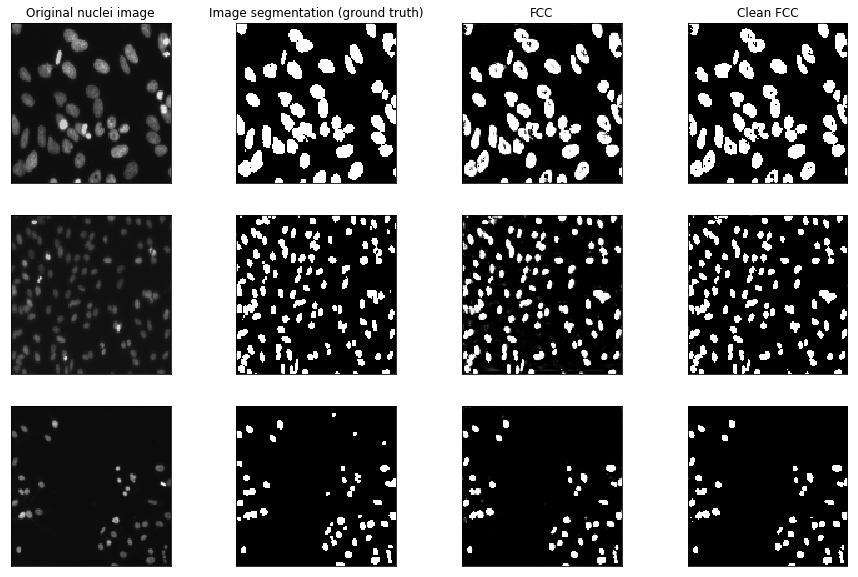

In [407]:
f, axarr = predict_segmentetion_plot(model_name = "FCC")

In [408]:
simple_iou(np.squeeze(preds_test_th[0]),np.squeeze(Y_test[0]))

0.89253231211105788

In [409]:
get_model_mean_iou()

mean test IOU:  0.789565065228  number of samples:  100
mean train IOU:  0.76762676382  number of samples:  570


## Predict on Unet

In [426]:
# model = load_model("{}.h5".format(Unet_model_name))
test_model_name = "U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5"
model = load_model(test_model_name)
preds_test = model.predict(X_test, verbose=1)
preds_train = model.predict(X_train, verbose=1)

570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s    


In [427]:
best_train_th, best_test_th =  get_threshold()
best_th = best_test_th

train threshold:  0.36901754386  test threshold:  0.3797


In [428]:
preds_train_th = (preds_train > best_th).astype(np.uint8)
preds_test_th = (preds_test > best_th).astype(np.uint8)

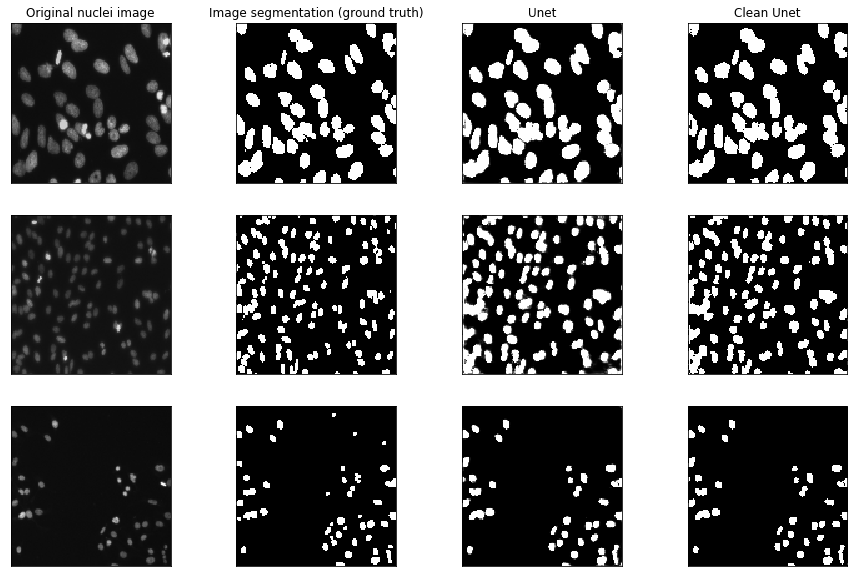

In [429]:
f, axarr = predict_segmentetion_plot(model_name = "Unet")

In [430]:
simple_iou(np.squeeze(preds_test_th[0]),np.squeeze(Y_test[0]))

0.87074679628811313

In [431]:
get_model_mean_iou()

mean test IOU:  0.753670445168  number of samples:  100
mean train IOU:  0.698591023399  number of samples:  570


## Predict on large Unet

In [454]:
model = load_model("{}.h5".format((large_Unet_model_name)))
# model = load_model(model_name)

preds_test = model.predict(X_test, verbose=1)
preds_train = model.predict(X_train, verbose=1)

570/570 [==============================] - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 11s    


In [455]:
best_train_th, best_test_th =  get_threshold()
best_th = best_test_th

train threshold:  0.431614035088  test threshold:  0.4281


In [456]:
preds_train_th = (preds_train > best_th).astype(np.uint8)
preds_test_th = (preds_test > best_th).astype(np.uint8)

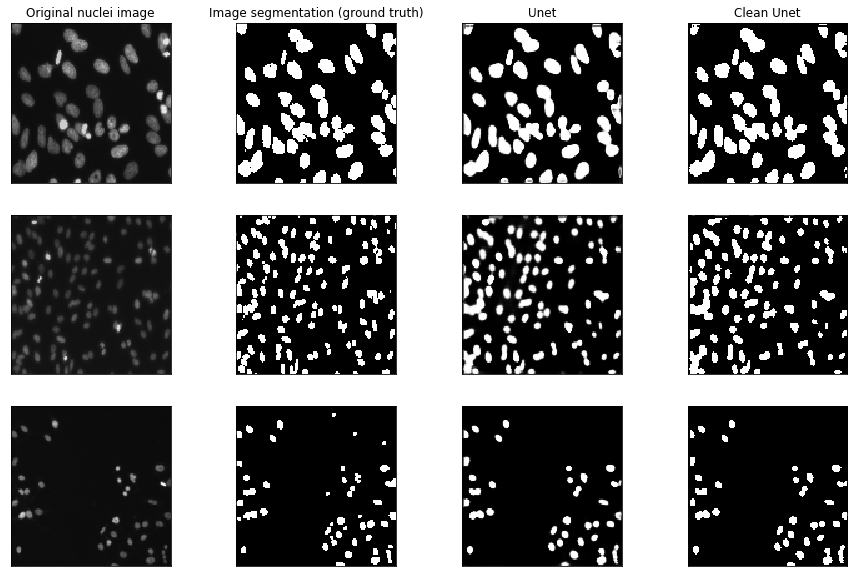

In [457]:
f, axarr = predict_segmentetion_plot(model_name = "Unet")

In [458]:
simple_iou(np.squeeze(preds_test_th[0]),np.squeeze(Y_test[0]))

0.87379779498006094

In [459]:
get_model_mean_iou()

mean test IOU:  0.7745620593  number of samples:  100
mean train IOU:  0.769377919875  number of samples:  570


# Investigating Encoding

In [36]:
encoder = load_model("encoder_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5")

OSError: Unable to open file (Unable to open file: name = 'encoder_large-u-net-v1_lr_decay_from_0.001_to_0.0001.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [ ]:
encoded_imgs = encoder.predict(X_train)
# decoded_imgs = decoder.predict(encoded_imgs)

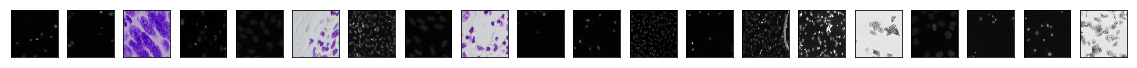

In [32]:
n = 20
f, axarr = plt.subplots(1,n,figsize=(20,10))
for i in range(n):
    index = i + 50
    a = encoded_imgs[index].reshape(32, 128).T
    axarr[i].imshow(X_train[index])
    remove_axis(axarr[i])

plt.show()

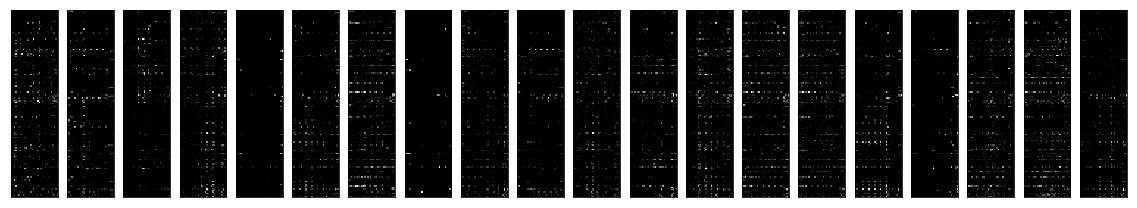

In [33]:
n = 20
f, axarr = plt.subplots(1,n,figsize=(20,10))
for i in range(n):
    index = i + 50
    a = encoded_imgs[index].reshape(32, 128).T
    axarr[i].imshow(a)
    remove_axis(axarr[i])

plt.show()

In [34]:
encoded_imgs.shape

(570, 8, 8, 64)

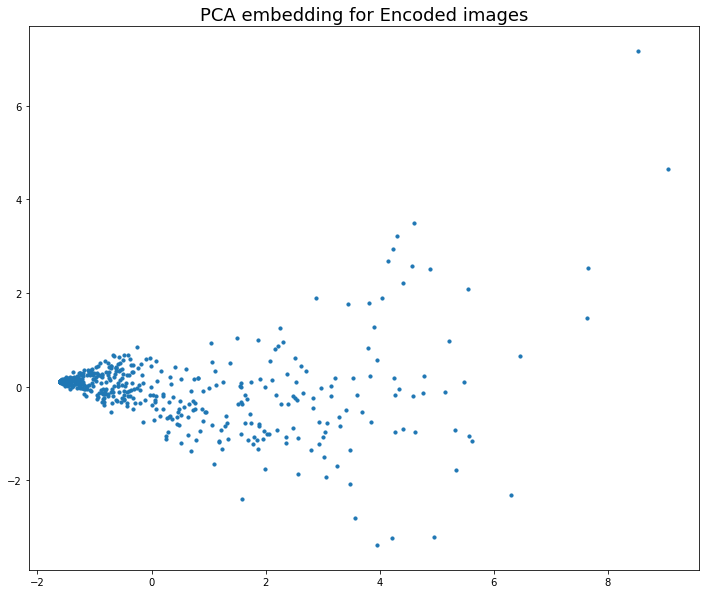

In [61]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform([x.reshape(4096) for x in encoded_imgs])
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=10)
plt.title("PCA embedding for Encoded images", fontsize=18)
plt.show()

In [59]:
embedding = umap.UMAP().fit_transform([x.reshape(4096) for x in encoded_imgs])

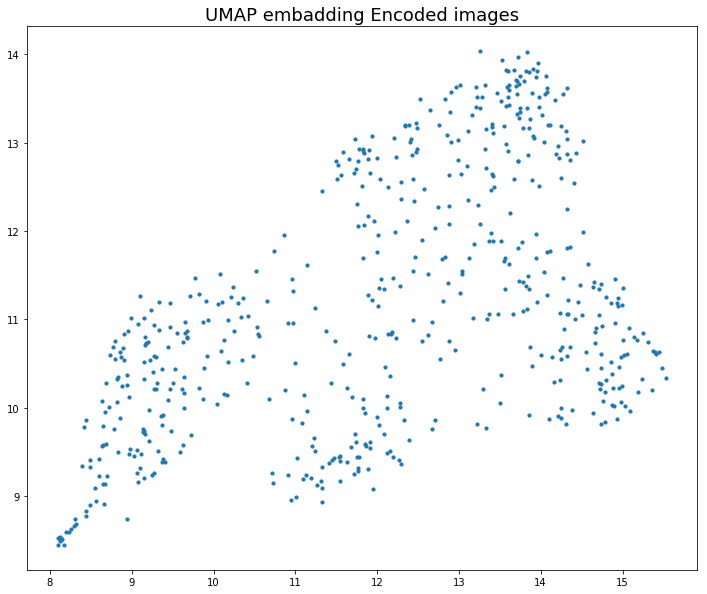

In [60]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
plt.title("UMAP embadding Encoded images", fontsize=18)
plt.show()

In [66]:
db = DBSCAN(eps=0.3, min_samples=7).fit(embedding)

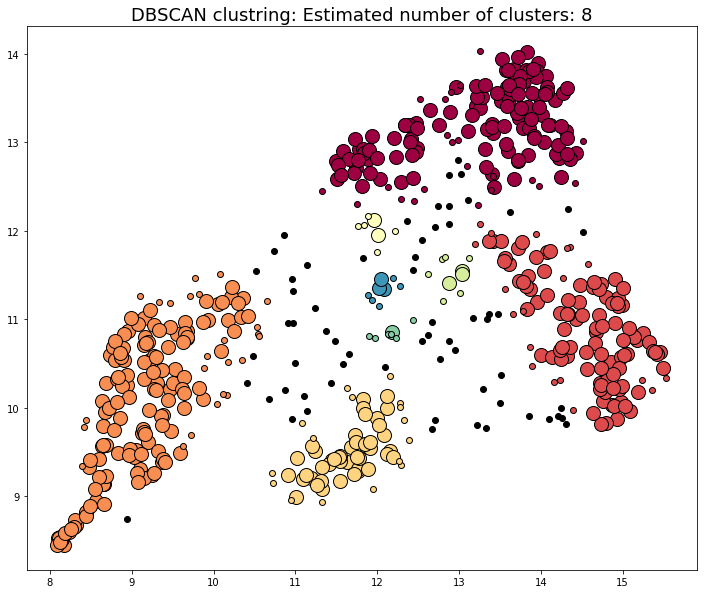

In [67]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig, ax = plt.subplots(figsize=(12, 10))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embedding[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = embedding[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN clustring: Estimated number of clusters: %d' % n_clusters_, fontsize=18)
plt.show()

In [100]:
def scatter_images_plot(images, embedding, unique_labels, colors, labels, title = "UMAP embedding of images"):

    def imscatter(x, y, images, ax=None, zoom=1.0):
        if ax is None:
            ax = plt.gca()
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0, img0 in zip(x, y, images):
            im = offsetbox.OffsetImage(img0, zoom=zoom)
            ab = offsetbox.AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists

    def plot_embedding(X, imgs):
        fig, ax = plt.subplots(figsize=(20, 20))
        ax = plt.subplot(111)
        for i in range(X.shape[0]):
            plt.text(X[i, 0], X[i, 1], ".", fontdict={'weight': 'bold', 'size': 9})
        if hasattr(offsetbox, 'AnnotationBbox'):
            imscatter(X[:,0], X[:,1], imgs, zoom=0.35, ax=ax)
            

    plot_embedding(embedding, X_train)
    plt.title(title, fontsize=20)
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue
        class_member_mask = (labels == k)
        xy = embedding[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=75)

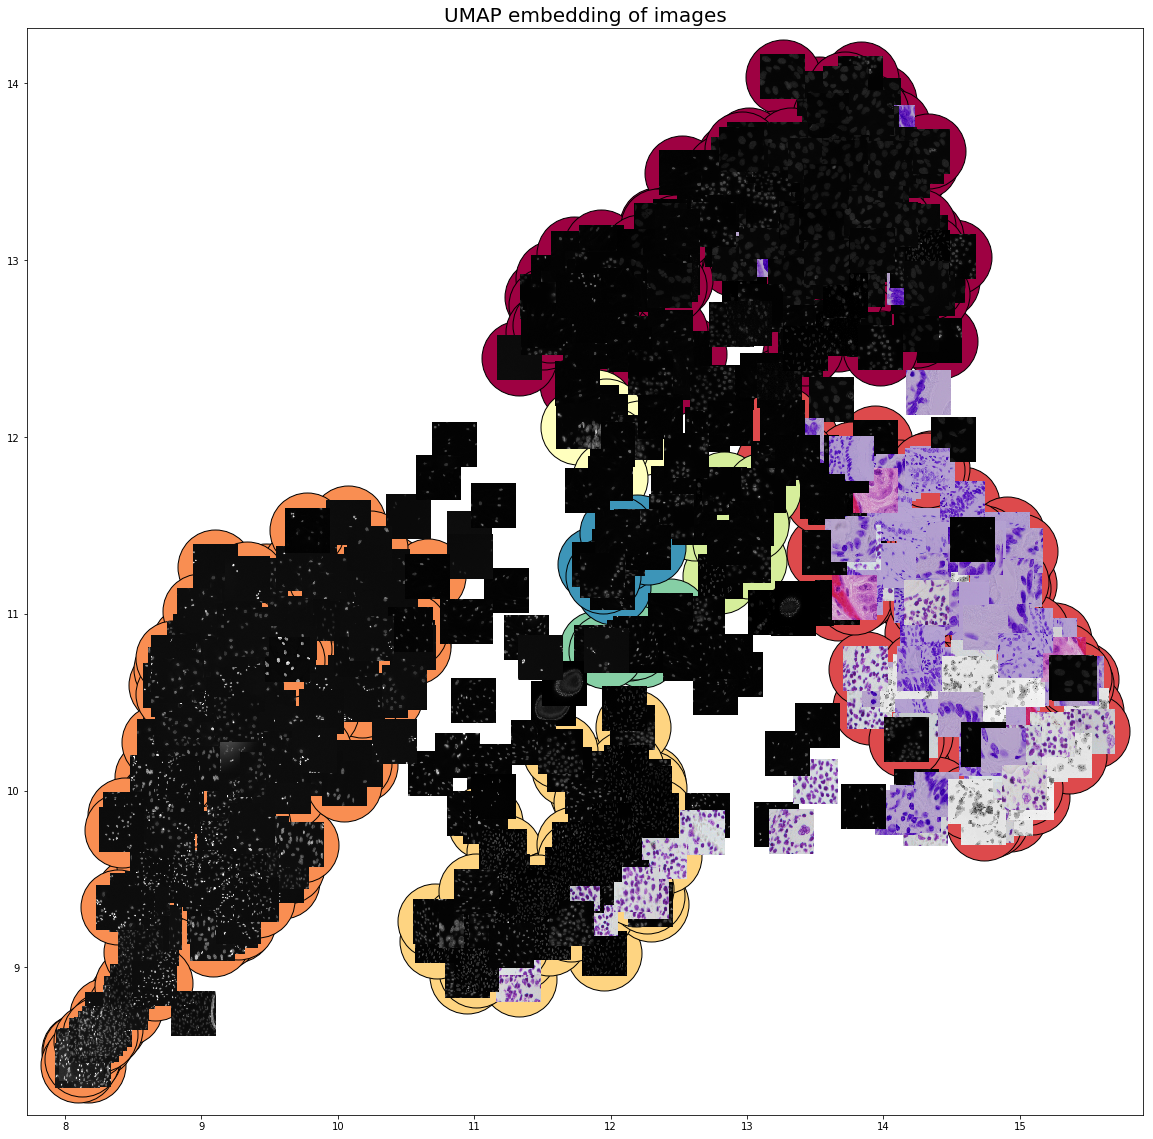

In [68]:
scatter_images_plot(X_train, embedding, unique_labels, colors, labels)

In [143]:
def investigate_encoding(encoder_name = "encoder_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5"):
    print('start investigate_encoding: ', encoder_name)
    encoder = load_model(encoder_name)
    encoded_imgs = encoder.predict(X_train)
    
    print('start umap embedding...')
    embedding = umap.UMAP().fit_transform([x.reshape(4096) for x in encoded_imgs])

    print('start DBSCAN...')
    db = DBSCAN(eps=0.3, min_samples=7).fit(embedding)
    
    labels = db.labels_
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    title =  "{} Embedding".format(encoder_name)
    scatter_images_plot(X_train, embedding, unique_labels, colors, labels, title)

In [133]:
def investigate_iou(model_name = "encoder_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5"):
    print('start investigate_iou: ', model_name)
    model = load_model(model_name)
    preds_test = model.predict(X_test, verbose=1)
    preds_train = model.predict(X_train, verbose=1)
    
    best_train_th, best_test_th =  get_threshold_local(preds_train,preds_test)
    best_th = best_test_th
    print('best_th: ', best_th)
    
    preds_train_th = (preds_train > best_th).astype(np.uint8)
    preds_test_th = (preds_test > best_th).astype(np.uint8)
    
    print('get_model_mean_iou_local: ')
    get_model_mean_iou_local(preds_test_th, preds_train_th)   
    
    f, axarr = predict_segmentetion_plot_local(model_name,  preds_test, preds_test_th, number_of_plots = 2)

start investigate_iou:  BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
570/570 [==============================] - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 17s    
train threshold:  0.49949122807  test threshold:  0.5816
best_th:  0.5816
get_model_mean_iou_local: 
mean test IOU:  0.261123211847  number of samples:  100
mean train IOU:  0.240190631176  number of samples:  570


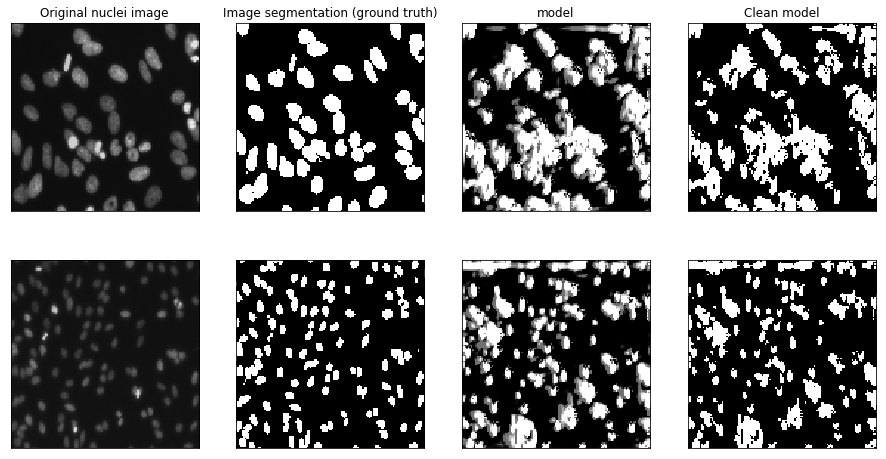

In [138]:
model_name = "BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5"
investigate_iou(model_name)

start investigate_encoding:  encoder_BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5


C:\Users\Sharon\Anaconda3\lib\site-packages\keras\models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


start umap embedding...
start DBSCAN...


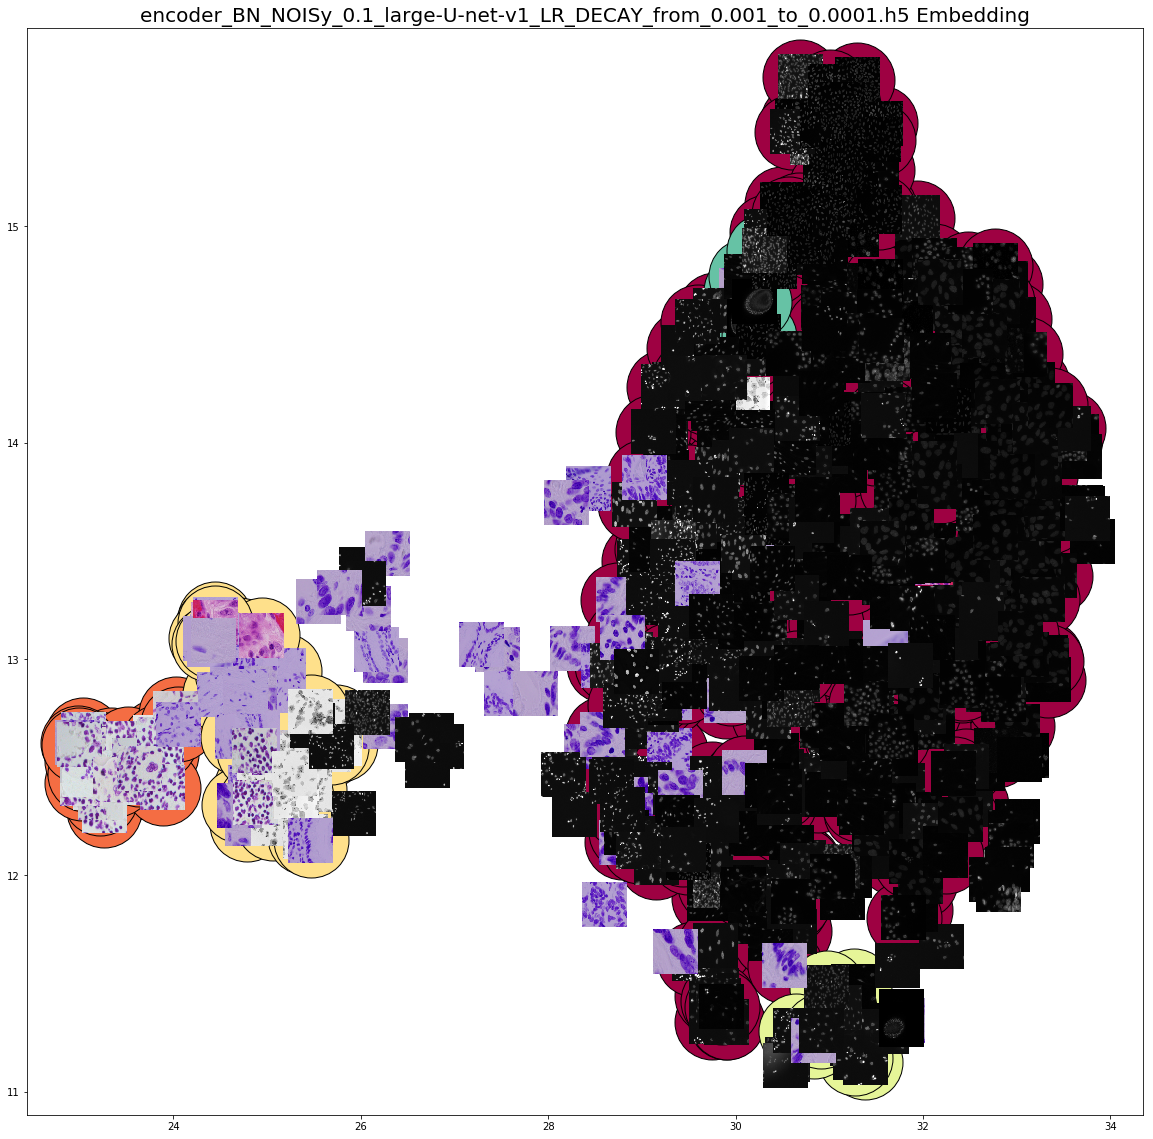

In [144]:
encoder_name = "encoder_BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5"
investigate_encoding(encoder_name)

# Denoising 

In [37]:
x_train_vec = X_train.astype('float32') / 255.
x_test_vec = X_test.astype('float32') / 255.
x_train_vec = x_train_vec.reshape((len(x_train_vec), np.prod(x_train_vec.shape[1:])))
x_test_vec = x_test_vec.reshape((len(x_test_vec), np.prod(x_test_vec.shape[1:])))
print(x_train_vec.shape)
print(x_test_vec.shape)

(570, 49152)
(100, 49152)


(128, 128, 3)


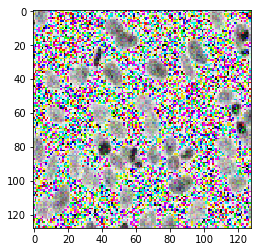

In [38]:
plt.imshow(X_test[0]+ 0.1* np.random.normal(loc=0.0, scale=1.0, size=X_test[0].shape))
print(X_test[0].shape)

In [39]:
def get_noisy_data(noise_factor = 0.1):
    x_train_noisy = x_train_vec + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_vec.shape) 
    x_test_noisy = x_test_vec + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_vec.shape) 
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    x_train_noisy = x_train_noisy.reshape(len(x_train_noisy), 128, 128, 3)
    x_test_noisy = x_test_noisy.reshape(len(x_test_noisy), 128, 128, 3)
    return x_train_noisy, x_test_noisy

In [40]:
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor = 0.1)

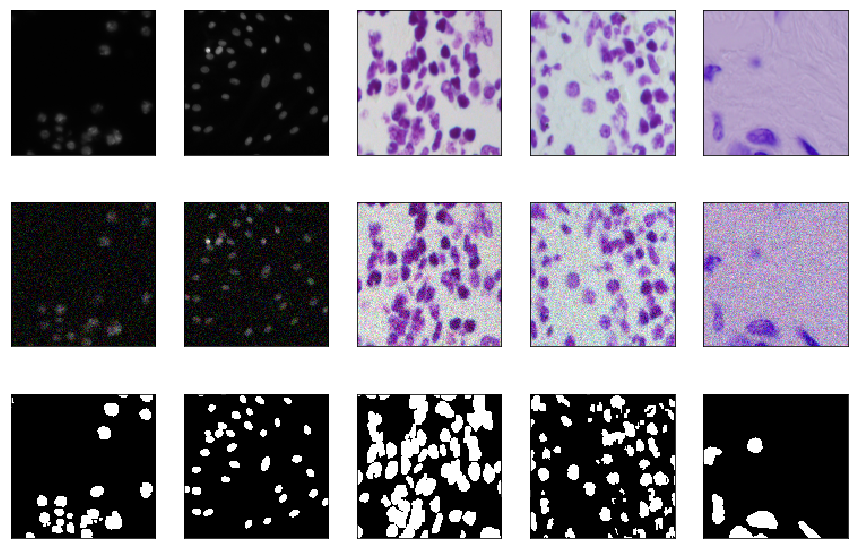

In [41]:
n = 5
f, axarr = plt.subplots(3,n,figsize=(15,10))
for i in range(n):
    axarr[0, i].imshow(X_train[i])
    axarr[1, i].imshow(x_train_noisy[i])
    axarr[2, i].imshow(np.squeeze(Y_train[i]))
    for j in range(0,3):
        remove_axis(axarr[j, i])

    
plt.show()

## Training denoising unet

In [146]:
def train_noisy_model(x_train_noisy, noise_factor, epochs_):
    model, encoder, decoder = large_unet()

    model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model_name =  "NOISy{}_{}_LR_DECAY_from_{}_to_{}.h5".format(noise_factor, large_Unet_model_name, START_LR, END_LR)

    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(x_train_noisy, Y_train, 
                        validation_split=VALIDATION_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epochs_, 
                        verbose=0,
                        callbacks=[checkpointer])
    decoder.save("decoder_{}".format(model_name))
    encoder.save("encoder_{}".format(model_name))

In [43]:
for noise_factor in [0.1, 0.2, 0.3, 0.4, 0.5]:
    x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
    train_noisy_model(x_train_noisy,noise_factor, epochs_ = 20)

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.44122, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.44122 to 0.43968, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.43968 to 0.43284, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.43284 to 0.43038, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.43038 to 0.42961, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.42961 to 0.42733, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss improved from 0.42733 to 0.42452, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss imp

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_3, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.67165, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67165 to 0.65171, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65171 to 0.63289, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63289 to 0.61559, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61559 to 0.59948, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59948 to 0.58468, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58468 to 0.57113, saving model to NOISy0.2_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57113 to 0.55858, saving model to NOISy0.2_large-U-net-v1_LR_DE

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_4, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.43648, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.43648 to 0.43611, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.43611 to 0.43079, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 0.43079 to 0.43041, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.43041 to 0.42957, saving model to NOISy0.3_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss improved from 0.42957 to 0.42916,

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_5, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.44155, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.44155 to 0.43658, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.43658 to 0.43344, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.43344 to 0.43120, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.43120 to 0.43092, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.43092 to 0.42954, saving model to NOISy0.4_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00011: val_loss did not improve
Ep

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 128, 128, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_6, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.43905, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.43905 to 0.43255, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.43255 to 0.43201, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.43201 to 0.43072, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.43072 to 0.42788, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.42788 to 0.42578, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss improved from 0.42578 to 0.42453, saving model to NOISy0.5_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did

In [147]:
noise_factor = 0.1
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67188, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67188 to 0.65165, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65165 to 0.63304, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63304 to 0.61548, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61548 to 0.59971, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59971 to 0.58465, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58465 to 0.57089, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57089 to 0.55818, saving model to NOISy0.1_large-U-net-v1_LR_DE

In [148]:
noise_factor = 0.125
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.65370, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.65370 to 0.58369, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.58369 to 0.49889, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.49889 to 0.44675, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.44675 to 0.43349, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.43349 to 0.43159, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.43159 to 0.43158, saving model to NOISy0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.43158 to 0.43158, saving model to NOISy0.125_larg

In [ ]:
noise_factor = 0
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67122, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67122 to 0.65101, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65101 to 0.63238, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63238 to 0.61518, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61518 to 0.59915, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59915 to 0.58435, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58435 to 0.57050, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57050 to 0.55790, saving model to NOISy0_large-U-net-v1_LR_DECAY_from_0.001_t

In [149]:
noise_factor = 0.05
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67143, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67143 to 0.65146, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65146 to 0.63283, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63283 to 0.61542, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61542 to 0.59918, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59918 to 0.58446, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58446 to 0.57078, saving model to NOISy0.05_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57078 to 0.55812, saving model to NOISy0.05_large-U-net-

In [ ]:
noise_factor = 0.1
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 200)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67140, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.67140 to 0.65125, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.65125 to 0.63263, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.63263 to 0.61518, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.61518 to 0.59915, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.59915 to 0.58436, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.58436 to 0.57056, saving model to NOISy0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.57056 to 0.55791, saving model to NOISy0.1_large-U-net-v1_LR_DE

In [50]:
noise_factor = 0.45
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_noisy_model(x_train_noisy,noise_factor, epochs_ = 100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.48303, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.48303 to 0.44952, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.44952 to 0.43788, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.43788 to 0.43463, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 0.43463 to 0.43453, saving model to NOISy0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00012: val_loss improved from 0.43453 to 0.43437, saving model to NOISy0.45_large-

## Training denoising with batch normalization

In [43]:
def bn_large_unet(input_size = (128,128,3)):

    inputs = Input(input_size)
    
    lambda1 = Lambda(lambda x: x / 255) (inputs)
    lambda1 = BatchNormalization()(lambda1)
    
    contract4, conv4 = Contracting(lambda1, 4)
    contract4 = BatchNormalization()(contract4)
    conv4 = BatchNormalization()(conv4)
    
    contract8, conv8 = Contracting(contract4, 8)
    contract8 = BatchNormalization()(contract8)
    conv8 = BatchNormalization()(conv8)
    
    contract16, conv16 = Contracting(contract8, 16)
    contract16 = BatchNormalization()(contract16)
    conv16 = BatchNormalization()(conv16)    
    
    contract32, conv32 = Contracting(contract16, 32)
    contract32 = BatchNormalization()(contract32)
    conv32 = BatchNormalization()(conv32)   
    
    convolve_n_drop64 = Conv_n_Dropout(contract32, 64)
    convolve_n_drop64 = BatchNormalization()(convolve_n_drop64)   
    
    expan32 = Expansive(convolve_n_drop64, conv32, 32)
    expan32 = BatchNormalization()(expan32)   
    
    expan16 = Expansive(expan32, conv16, 16)
    expan16 = BatchNormalization()(expan16)     
    
    expan8 = Expansive(expan16, conv8, 8)
    expan8 = BatchNormalization()(expan8)  
    
    expan4 = Expansive(expan8, conv4, 4)
    expan4 = BatchNormalization()(expan4)  
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    autoencoder = Model(input = inputs, output = conv1)
    
    encoder = Model(inputs, convolve_n_drop64)

    # create a placeholder for an encoded input
    encoded_input = Input(shape= (8, 8, 64), name="encoded_input")
    decoder_layer = autoencoder.get_layer("decoder")
    decoder = Model(encoded_input, decoder_layer(encoded_input), name="decoder")
    
    return autoencoder, encoder, decoder

In [44]:
def train_bn_noisy_model(x_train_noisy, noise_factor, epochs_):
    model, encoder, decoder = bn_large_unet()

    model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model_name =  "BN_NOISy_{}_{}_LR_DECAY_from_{}_to_{}.h5".format(noise_factor, large_Unet_model_name, START_LR, END_LR)

    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(x_train_noisy, Y_train, 
                        validation_split=VALIDATION_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epochs_, 
                        verbose=0,
                        callbacks=[checkpointer])
    print(results)
    decoder.save("decoder_{}".format(model_name))
    encoder.save("encoder_{}".format(model_name))

In [60]:
noise_factor = 0.15
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_bn_noisy_model(x_train_noisy,noise_factor, epochs_ =epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.67380, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.67380 to 0.56179, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.56179 to 0.55952, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 0.55952 to 0.49948, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 0.49948 to 0.32473, saving model to BN_NOISy_0.15_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 0.32473 to 0.17402, saving model

In [61]:
noise_factor = 0.1
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_bn_noisy_model(x_train_noisy,noise_factor, epochs_ =epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.44732, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.44732 to 0.40977, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.40977 to 0.38723, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00011: val_loss improved from 0.38723 to 0.14249, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00012: val_loss improved from 0.14249 to 0.13228, saving model to BN_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00013: val_loss did not impro

### using batch size 32

In [56]:
noise_factor = 0.1
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)

model, encoder, decoder = bn_large_unet()

model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "BN_e32_NOISy_{}_{}_LR_DECAY_from_{}_to_{}.h5".format(noise_factor, large_Unet_model_name, START_LR, END_LR)

checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
results = model.fit(x_train_noisy, Y_train, 
                    validation_split=VALIDATION_SPLIT, 
                    batch_size=32, 
                    epochs=100, 
                    verbose=0,
                    callbacks=[checkpointer])
print(results)
decoder.save("decoder_{}".format(model_name))
encoder.save("encoder_{}".format(model_name))
train_bn_noisy_model(x_train_noisy,noise_factor, epochs_ =epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.61622, saving model to BN_e32_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.61622 to 0.57416, saving model to BN_e32_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.57416 to 0.46756, saving model to BN_e32_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.46756 to 0.43644, saving model to BN_e32_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve


KeyboardInterrupt: 

## Training denoiser with BN and leaky relu activation

In [45]:
def batch_leaky_conv2d(inputs, dim, kernel_size):
    conv = Conv2D(dim, kernel_size, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)
    return conv

def Contracting_leaky(inputs, dim):
    conv = batch_leaky_conv2d(inputs, dim, 3)
    conv = batch_leaky_conv2d(conv, dim, 3)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return pool , conv

def Expansive_leaky(inputs, parallel_conv, dim):
    up = UpSampling2D(size = (2,2))(inputs)
    up = batch_leaky_conv2d(up, dim, 2)
    merge_l = concatenate([parallel_conv,up], axis=3)
    conv = batch_leaky_conv2d(merge_l, dim, 3)
    conv = batch_leaky_conv2d(conv, dim, 3)
    return conv

def Conv_n_Dropout_leaky(inputs, dim):
    conv = batch_leaky_conv2d(inputs, dim, 3)
    conv = batch_leaky_conv2d(conv, dim, 3)
    drop = Dropout(0.5 ,  name='decoder')(conv)
    return drop
    

In [46]:
def bn_leaky_large_unet(input_size = (128,128,3)):
    inputs = Input(input_size)
    
    lambda1 = Lambda(lambda x: x / 255) (inputs)
    contract4, conv4 = Contracting_leaky(lambda1, 4)
    contract8, conv8 = Contracting_leaky(contract4, 8)
    contract16, conv16 = Contracting_leaky(contract8, 16)  
    contract32, conv32 = Contracting_leaky(contract16, 32)
    convolve_n_drop64 = Conv_n_Dropout_leaky(contract32, 64)
    expan32 = Expansive_leaky(convolve_n_drop64, conv32, 32)
    expan16 = Expansive_leaky(expan32, conv16, 16)
    expan8 = Expansive_leaky(expan16, conv8, 8)
    expan4 = Expansive_leaky(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    autoencoder = Model(input = inputs, output = conv1)
    
    encoder = Model(inputs, convolve_n_drop64)

    # create a placeholder for an encoded input
    encoded_input = Input(shape= (8, 8, 64), name="encoded_input")
    decoder_layer = autoencoder.get_layer("decoder")
    decoder = Model(encoded_input, decoder_layer(encoded_input), name="decoder")
    
    return autoencoder, encoder, decoder

In [ ]:
def train_leaky_bn_noisy_model(x_train_noisy, noise_factor, epochs_):
    
    model, encoder, decoder = bn_leaky_large_unet()
    model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model_name =  "BN_LEAKY_NOISy_{}_{}_LR_DECAY_from_{}_to_{}.h5".format(noise_factor, large_Unet_model_name, START_LR, END_LR)

    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(x_train_noisy, Y_train, 
                        validation_split=VALIDATION_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epochs_, 
                        shuffle=True, 
                        verbose=0,
                        callbacks=[checkpointer])

    decoder.save("decoder_{}".format(model_name))
    encoder.save("encoder_{}".format(model_name))

In [49]:
noise_factor = 0.125
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_leaky_bn_noisy_model(x_train_noisy,noise_factor, epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.46508, saving model to BN_LEAKY_NOISy_0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.46508 to 0.43926, saving model to BN_LEAKY_NOISy_0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.43926 to 0.34571, saving model to BN_LEAKY_NOISy_0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss improved from 0.34571 to 0.19785, saving model to BN_LEAKY_NOISy_0.125_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss 

KeyboardInterrupt: 

In [51]:
noise_factor = 0.45
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_leaky_bn_noisy_model(x_train_noisy,noise_factor, epoches)


C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.46514, saving model to BN_LEAKY_NOISy_0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.46514 to 0.41825, saving model to BN_LEAKY_NOISy_0.45_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss did not improve
Epoch 00019: val_loss did not improve
Epoch 00020: val_loss did not improve
Ep

In [52]:
noise_factor = 0.1
epoches = 100
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_leaky_bn_noisy_model(x_train_noisy,noise_factor, epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.66778, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.66778 to 0.64173, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.64173 to 0.60414, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.60414 to 0.59730, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00004: val_loss improved from 0.59730 to 0.49529, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.49529 to 0.43392, saving model to BN_LEAKY_NOISy_0.1_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_l

In [53]:
noise_factor = 0.11
epoches = 150
x_train_noisy, x_test_noisy = get_noisy_data(noise_factor)
train_leaky_bn_noisy_model(x_train_noisy,noise_factor, epoches)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 00000: val_loss improved from inf to 0.66853, saving model to BN_LEAKY_NOISy_0.11_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.66853 to 0.48072, saving model to BN_LEAKY_NOISy_0.11_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.48072 to 0.43873, saving model to BN_LEAKY_NOISy_0.11_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: v

In [54]:
Y_train.shape

(570, 128, 128, 1)

In [55]:
X_train.shape

(570, 128, 128, 3)

# Convolutional autoencoder

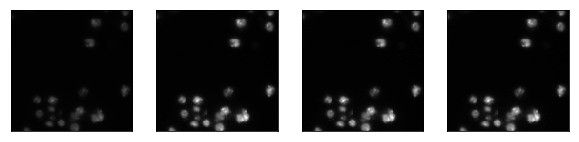

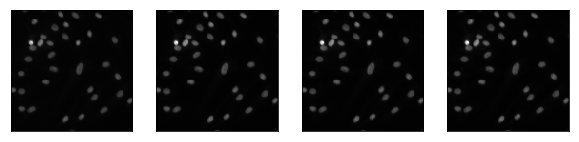

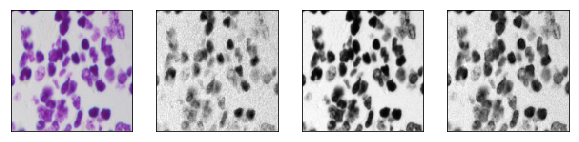

In [270]:
def plot_RGB(image):
    b = image.copy()[:, :, 0]
    g = image.copy()[:, :, 1]
    r = image.copy()[:, :, 2]
    
    f, axarr = plt.subplots(1,4,figsize=(10,5))
    axarr[0].imshow(image)
    axarr[1].imshow(r)
    axarr[2].imshow(g)
    axarr[3].imshow(b)
    for l in range(0,4):
        remove_axis(axarr[l])
        
for i in range(0,3):
    plot_RGB(X_train[i])

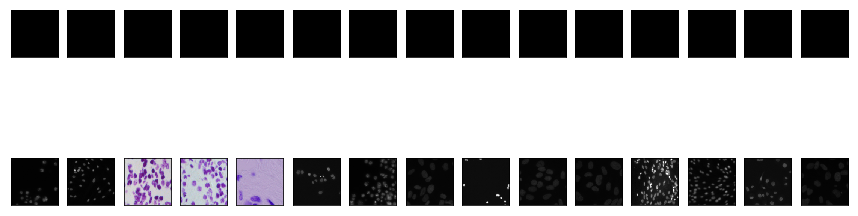

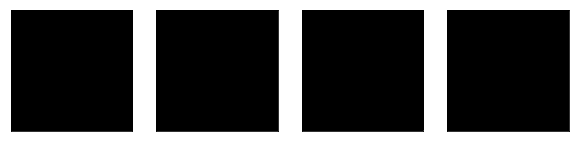

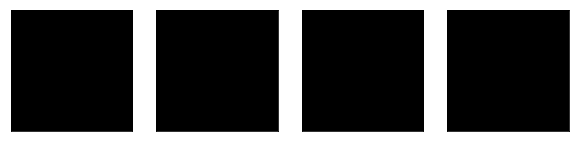

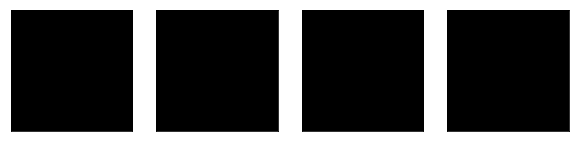

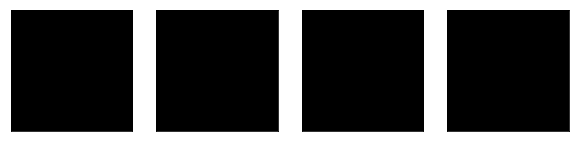

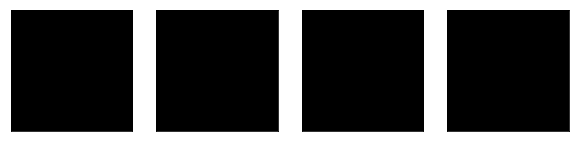

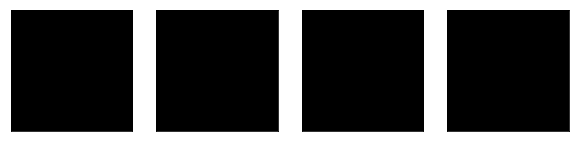

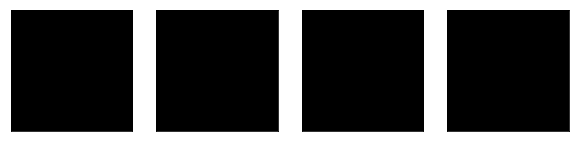

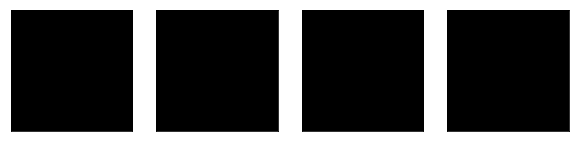

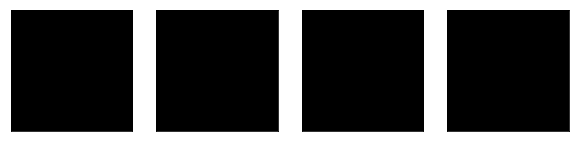

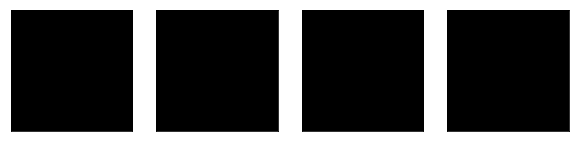

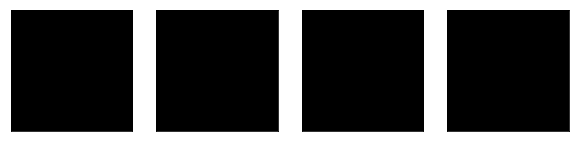

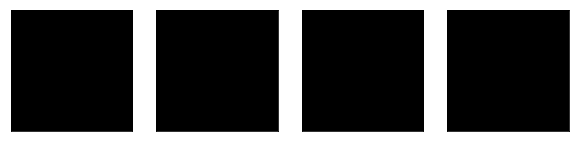

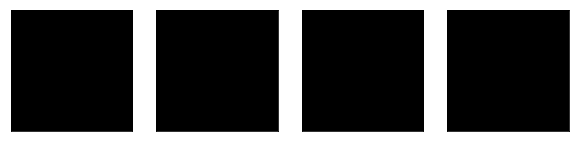

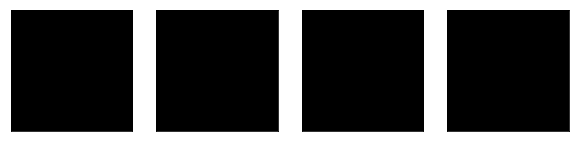

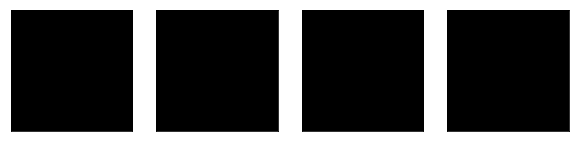

In [271]:
k = 15
f, axarr = plt.subplots(2,k,figsize=(k,5))
for i in range(0,k):
    axarr[0,i].imshow(preds_train[i])
    axarr[1,i].imshow(X_train[i])
    remove_axis(axarr[0,i])
    remove_axis(axarr[1,i])
    
    plot_RGB(preds_train[i])

In [272]:
def print_model(model_name):
    test_model_name = model_name
    model = load_model(test_model_name)
    preds_test = model.predict(X_test, verbose=1)
    preds_train = model.predict(X_train, verbose=1)
    best_th = 0.1
    f, axarr = predict_segmentetion_plot(model_name = "Unet")